 ## Introduction
This notebook was created for analysis and prediction making of the Auto MPG data set from UCI Machine Learning Library. The data set can be accessed separately from the UCI Machine Learning Repository page, [here](http://archive.ics.uci.edu/ml/datasets/Auto+MPG).

## Description
The following description can be found on the UCI Repository page for the data set.

- "This dataset is a slightly modified version of the dataset provided in the StatLib library. In line with the use by Ross Quinlan (1993) in predicting the attribute "mpg", 8 of the original instances were removed because they had unknown values for the "mpg" attribute. The original data set is available in the file "auto-mpg.data-original"".

- "The data concerns city-cycle fuel consumption in miles per gallon, to be predicted in terms of 3 multivalued discrete and 5 continuous attributes." (Quinlan, 1993)


## Relevant Papers

In his paper "Combining Instance-Based and Model-Based Learning", (Quinlan,R., 1993), which can be found [here](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.34.6358&rep=rep1&type=pdf), Quinlan tries to predict the city cycle consumption in miles per galon, using three methods: Linear Regression, Model trees and Neural Networks.

## Models

We will create 3 models in order to make predictions and compare them with the original paper. These models are:
- Linear Regression
- Decision tree
- Neural Network

After the initial predictions, each model will be "optimized" by `GridSearchCV` estimator, which will search for the best set of hyperparameters for every model.  

## Goal

Using the models above, we will try to predict the class value of `y` column with better scores, than the scores presented in the original paper. For our model, we will use the original full data set (**auto-mpg_data-original.csv**).

## Import libraries/packages

In [340]:
### General libraries ###
import pandas as pd
from pandas.api.types import CategoricalDtype
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import os
import graphviz 
from graphviz import Source
from IPython.display import SVG

##################################

### ML Models ###
from sklearn.linear_model import LinearRegression
from sklearn import tree
from sklearn.tree.export import export_text
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler

##################################

### Metrics ###
from sklearn import metrics
from sklearn.metrics import r2_score,f1_score,confusion_matrix, mean_squared_error, mean_absolute_error, classification_report, roc_auc_score, roc_curve, precision_score, recall_score

## Part 1: Load and clean the data

In [304]:
# Read the data from the auto-mpg_data-original.csv file.
ds=pd.read_csv("auto-mpg_data-original.csv")

In [305]:
# Examine the data types and the number of non-null items.
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 406 entries, 0 to 405
Data columns (total 9 columns):
mpg             398 non-null float64
cylinders       406 non-null float64
displacement    406 non-null float64
horsepower      400 non-null float64
weight          406 non-null float64
acceleration    406 non-null float64
model year      406 non-null float64
origin          406 non-null float64
car name        406 non-null object
dtypes: float64(8), object(1)
memory usage: 28.7+ KB


In [306]:
# Display the shape of the data.
print("The data frame has {} rows and {} columns.".format(ds.shape[0],ds.shape[1]))

The data frame has 406 rows and 9 columns.


In [307]:
# Statistics for the data set.
ds.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
mpg,398.0,23.514573,7.815984,9.0,17.50,23.0,29.000,46.6
cylinders,406.0,5.475369,1.712160,3.0,4.00,4.0,8.000,8.0
displacement,406.0,194.779557,104.922458,68.0,105.00,151.0,302.000,455.0
horsepower,400.0,105.082500,38.768779,46.0,75.75,95.0,130.000,230.0
weight,406.0,2979.413793,847.004328,1613.0,2226.50,2822.5,3618.250,5140.0
acceleration,406.0,15.519704,2.803359,8.0,13.70,15.5,17.175,24.8
model year,406.0,75.921182,3.748737,70.0,73.00,76.0,79.000,82.0
origin,406.0,1.568966,0.797479,1.0,1.00,1.0,2.000,3.0


In [308]:
# Check for duplicate rows.
print(f"There are {ds.duplicated().sum()} duplicate rows in the data set.")

There are 0 duplicate rows in the data set.


In [309]:
# Number of null values for each attribute.
ds.isnull().sum()

mpg             8
cylinders       0
displacement    0
horsepower      6
weight          0
acceleration    0
model year      0
origin          0
car name        0
dtype: int64

The rows with a null value from the `mpg` attribute can be seen below:

In [310]:
# Rows with null value at the "mpg" column.
ds[ds['mpg'].isnull()]

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
10,NaN,4.0,133.0,115.0,3090.0,17.5,70.0,2.0,citroen ds-21 pallas
11,NaN,8.0,350.0,165.0,4142.0,11.5,70.0,1.0,chevrolet chevelle concours (sw)
12,NaN,8.0,351.0,153.0,4034.0,11.0,70.0,1.0,ford torino (sw)
13,NaN,8.0,383.0,175.0,4166.0,10.5,70.0,1.0,plymouth satellite (sw)
14,NaN,8.0,360.0,175.0,3850.0,11.0,70.0,1.0,amc rebel sst (sw)
17,NaN,8.0,302.0,140.0,3353.0,8.0,70.0,1.0,ford mustang boss 302
39,NaN,4.0,97.0,48.0,1978.0,20.0,71.0,2.0,volkswagen super beetle 117
367,NaN,4.0,121.0,110.0,2800.0,15.4,81.0,2.0,saab 900s


The above rows provide no usefull information because the class attribute value is missing. Hence, we cannot use them as a training nor a test set for our model, so they will be removed them from the dataset. For now, we store them for a potential future use.

In [311]:
# Store rows with a missing value at "mpg" attribute as a prediction set for future use.
prediction_set=ds[ds['mpg'].isnull()].drop('mpg',axis=1)

The rows with null values in the `horsepower` column can be seen below:

In [312]:
# Rows with null value at the "horsepower" column.
ds[ds['horsepower'].isnull()]

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
38,25.0,4.0,98.0,NaN,2046.0,19.0,71.0,1.0,ford pinto
133,21.0,6.0,200.0,NaN,2875.0,17.0,74.0,1.0,ford maverick
337,40.9,4.0,85.0,NaN,1835.0,17.3,80.0,2.0,renault lecar deluxe
343,23.6,4.0,140.0,NaN,2905.0,14.3,80.0,1.0,ford mustang cobra
361,34.5,4.0,100.0,NaN,2320.0,15.8,81.0,2.0,renault 18i
382,23.0,4.0,151.0,NaN,3035.0,20.5,82.0,1.0,amc concord dl


In [313]:
# Fill the null values of "horsepower" with the mean of "horsepower".
ds['horsepower']=ds['horsepower'].fillna(ds['horsepower'].mean())

In [314]:
# Remove rows from the data set with a null values.
new_ds=ds.dropna()

According to the description of the data set, the columns `cylinders`,`model year` and `origin` are discrete multivalued. Hence , it's more appropriate that they can be treated as a category type feature rather than an integeer type. 

In [315]:
# Value distributions for columns 'cylinders','model year' and 'origin'.
for col in ['cylinders','model year', 'origin']:
    print(new_ds[col].value_counts(),'\n')

4.0    204
8.0    103
6.0     84
3.0      4
5.0      3
Name: cylinders, dtype: int64 

73.0    40
78.0    36
76.0    34
82.0    31
75.0    30
81.0    29
80.0    29
79.0    29
70.0    29
77.0    28
72.0    28
71.0    28
74.0    27
Name: model year, dtype: int64 

1.0    249
3.0     79
2.0     70
Name: origin, dtype: int64 



In [317]:
# Change columns to "category" type.
for col in ['cylinders','model year', 'origin']:
    new_ds[col]=new_ds[col].astype('category')

In [318]:
# Information about the new "clean" data set.
new_ds.info()

# Display the shape of the data.
print("\nThe new data frame has {} rows and {} columns.".format(new_ds.shape[0],new_ds.shape[1]))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 398 entries, 0 to 405
Data columns (total 9 columns):
mpg             398 non-null float64
cylinders       398 non-null category
displacement    398 non-null float64
horsepower      398 non-null float64
weight          398 non-null float64
acceleration    398 non-null float64
model year      398 non-null category
origin          398 non-null category
car name        398 non-null object
dtypes: category(3), float64(5), object(1)
memory usage: 24.0+ KB

The new data frame has 398 rows and 9 columns.


In [319]:
# Statistics for the new data set.
new_ds.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
mpg,398.0,23.514573,7.815984,9.0,17.500,23.0,29.000,46.6
displacement,398.0,193.425879,104.269838,68.0,104.250,148.5,262.000,455.0
horsepower,398.0,104.478631,38.199261,46.0,76.000,95.0,125.000,230.0
weight,398.0,2970.424623,846.841774,1613.0,2223.750,2803.5,3608.000,5140.0
acceleration,398.0,15.568090,2.757689,8.0,13.825,15.5,17.175,24.8


<Figure size 1440x1440 with 0 Axes>

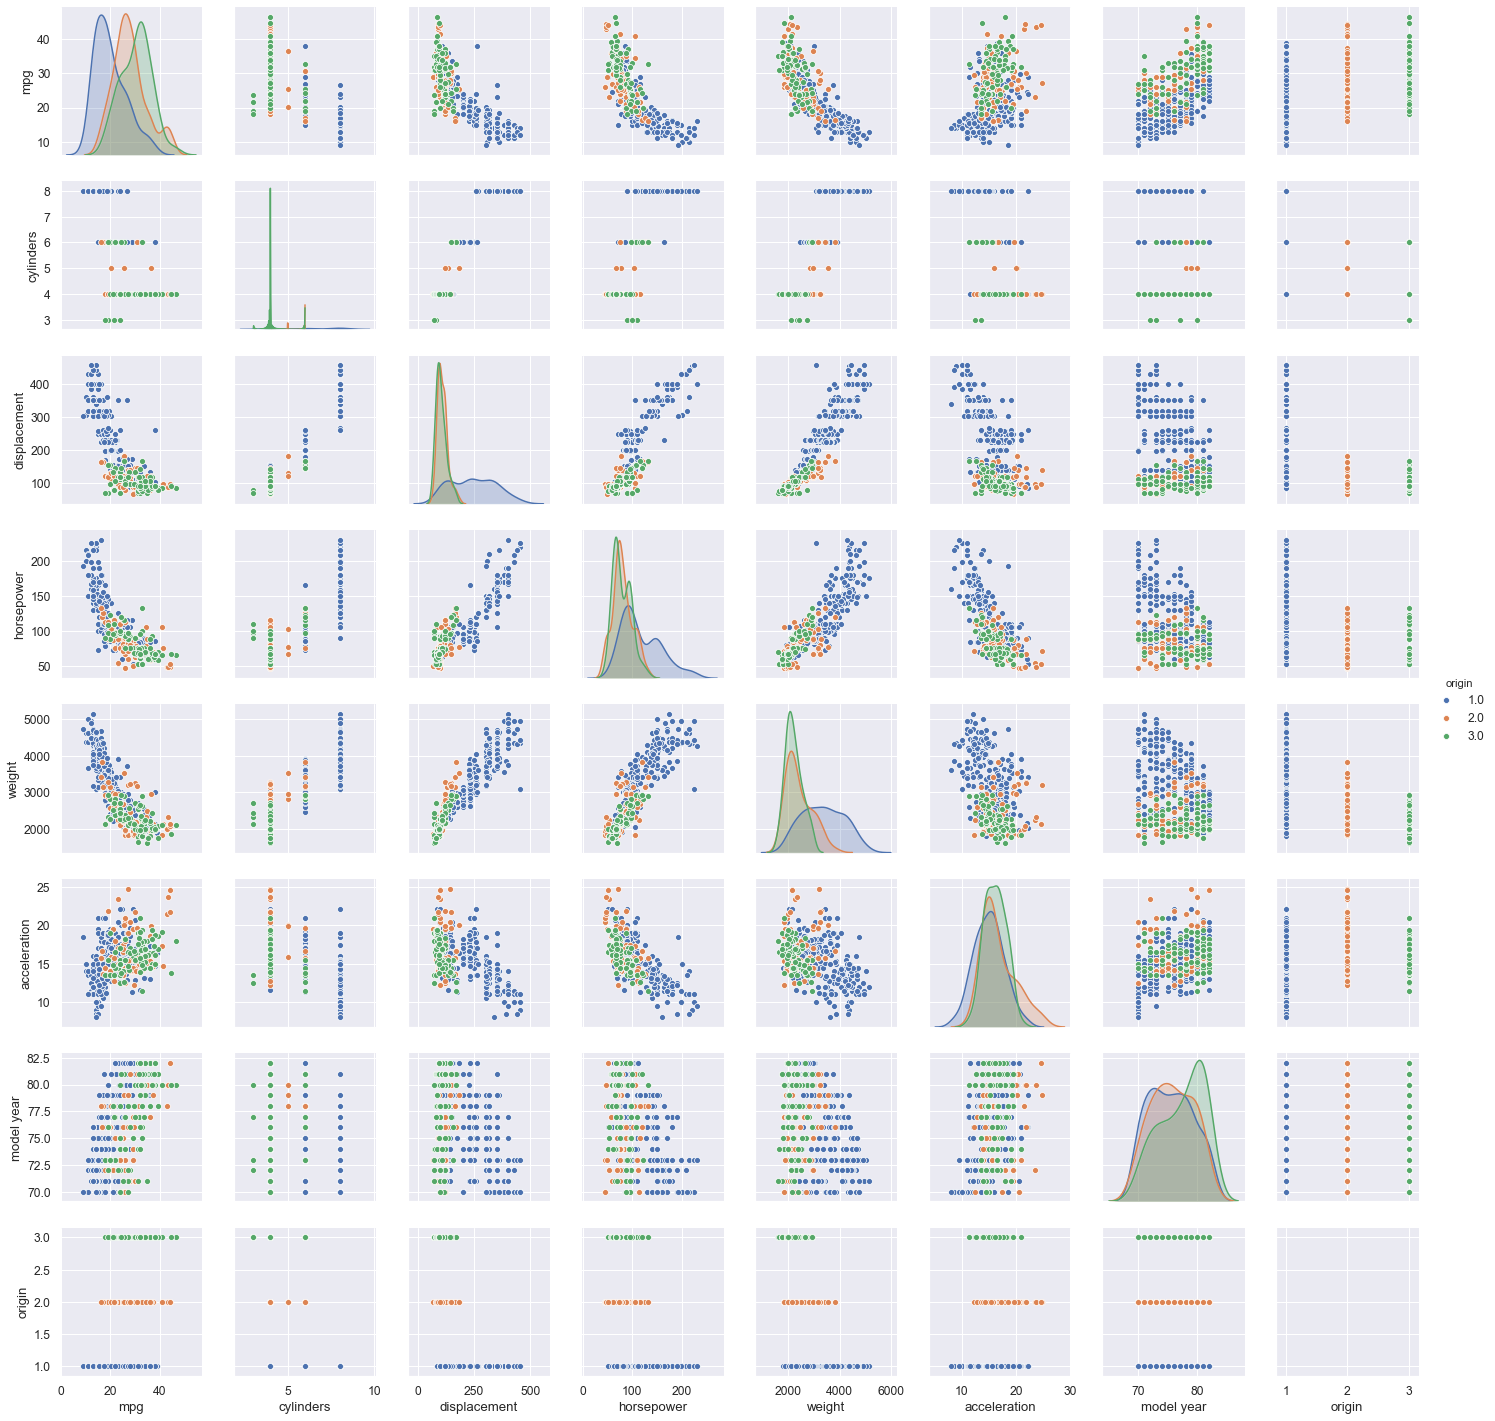

In [320]:
# Plotting a pairplot for the new data set.
plt.figure(figsize=(20,20))
sns.set(font_scale=1.1)
sns.pairplot(data=new_ds, diag_kind='kde', hue='origin');
plt.show();

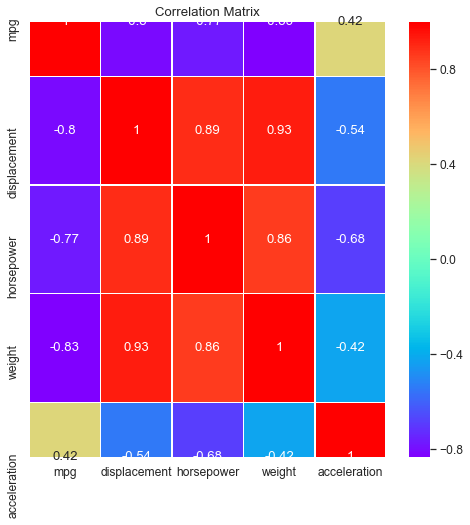

In [321]:
# Plotting a correlation heatmap for the new data set.
corr = new_ds.corr()
plt.figure(figsize=(8,8))
sns.set(font_scale=1.1)
sns.heatmap(data=corr,annot=True,cmap='rainbow',linewidth=0.5)
plt.title('Correlation Matrix')
plt.show();

## Part 2: Preproccesing
In this part we prepare the data for our models. This means that we choose the columns that will be our independed variables and which column the target that we want to predict.

In [322]:
# Create dummy columns for columns 'cylinders','model year' and 'origin'.
new_ds = pd.get_dummies(new_ds, columns=['cylinders','model year', 'origin'])

In [323]:
# Select feature and target columns.
features=['displacement','horsepower','weight','acceleration','cylinders_3.0','cylinders_4.0','cylinders_5.0','cylinders_6.0',
          'cylinders_8.0','model year_70.0','model year_71.0','model year_72.0','model year_73.0','model year_74.0',
          'model year_75.0','model year_76.0','model year_77.0','model year_78.0','model year_79.0','model year_80.0',
          'model year_81.0','model year_82.0','origin_1.0','origin_2.0','origin_3.0']
target=['mpg']
X=new_ds[features]
y=new_ds[target]

In [324]:
# Split to train and test sets. 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=25)

In [325]:
# Standardization
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Part 3: Modeling
In this section we build and try 3 models:
- Linear Regression
- Decision tree
- Neural network

Each model will be trained and make a prediction for the test set. Accuracy, precision, recall, f1-score, confusion matrix and ROC will be calculated for each model. Then we will use the GridSearchCV module to tune our models and search for the best hyperparameters in order to increase the accuracy of each model.

## Linear Regression

In [326]:
# Initialize a Logistic Regression estimator.
linreg=LinearRegression(n_jobs=-1)

# Train the estimator.
linreg.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [327]:
# Make predictions.
lin_pred=linreg.predict(X_test)

# Calculate CV score.
cv_lin_reg=cross_val_score(linreg, X_train, y_train, cv=10).mean()

## Linear Regression Metrics

In [343]:
# Mean squared error (relative error).
print("Mean squared error (MSE): %.2f" % mean_squared_error(y_test, lin_pred))

# Mean absolute error (average error).
print("Mean absolute error (MAE): %.2f" % mean_absolute_error(y_test, lin_pred))

# Cross-Validation accuracy
print('Cross-validation accuracy: %0.1f' % (cv_lin_reg*100),'%')

# Accuracy score: 1 is perfect prediction.
print('Accuracy: %.1f' % (linreg.score(X_test, y_test)*100),'%')

Mean squared error (MSE): 8.38
Mean absolute error (MAE): 2.10
Cross-validation accuracy: 83.4 %
Accuracy: 85.9 %


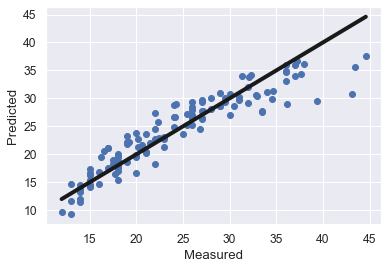

In [338]:
fig,ax = plt.subplots()
ax.scatter(y_test, lin_pred)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k-', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
fig.show()

## Grid search for Linear Regression

In [297]:
# Hyperparameters to be checked.
parameters = {'normalize':[True, False],
              'fit_intercept':[True, False]
             }

# Linear Regression estimator.
default_linreg=LinearRegression(n_jobs=-1)

# GridSearchCV estimator.
gs_linreg = GridSearchCV(default_linreg, parameters, cv=10, n_jobs=-1, verbose=1)

# Train the GridSearchCV estimator and search for the best parameters.
gs_linreg.fit(X_train,y_train)

Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    5.9s finished


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=LinearRegression(copy_X=True, fit_intercept=True,
                                        n_jobs=-1, normalize=False),
             iid='warn', n_jobs=-1,
             param_grid={'fit_intercept': [True, False],
                         'normalize': [True, False]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=1)

In [298]:
# Make predictions with the best parameters.
gs_linreg_pred=gs_linreg.predict(X_test)

## Grid search Metrics for Linear Regression

In [299]:
# Best parameters.
print("Best Linear Regression Parameters: {}".format(gs_linreg.best_params_))

# Mean squared error (relative error).
print("Mean squared error (MSE): %.2f" % mean_squared_error(y_test, gs_linreg_pred))

# Mean absolute error (average error).
print("Mean absolute error (MAE): %.2f" % mean_absolute_error(y_test, gs_linreg_pred))

# Cross validation accuracy for the best parameters.
print('Cross-validation accuracy: %0.1f' % (gs_linreg.best_score_*100),'%')

# Accuracy score: 1 is perfect prediction.
print('Accuracy: %.1f' % (gs_linreg.score(X_test, y_test)*100),'%')

Best Linear Regression Parameters: {'fit_intercept': False, 'normalize': True}
Mean squared error (MSE): 585.75
Mean absolute error (MAE): 23.89
Cross-validation accuracy: -1685810255508227419294138368.0 %
Accuracy: -881.8 %


## Decision tree

In [145]:
# Initialize a decision tree estimator.
tr = tree.DecisionTreeRegressor(max_depth=3, random_state=25)

# Train the estimator.
tr.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=25, splitter='best')

In [146]:
# Plot the tree.

os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

dot_data = tree.export_graphviz(tr, out_file=None, feature_names=X.columns, filled=True, rounded=True, special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

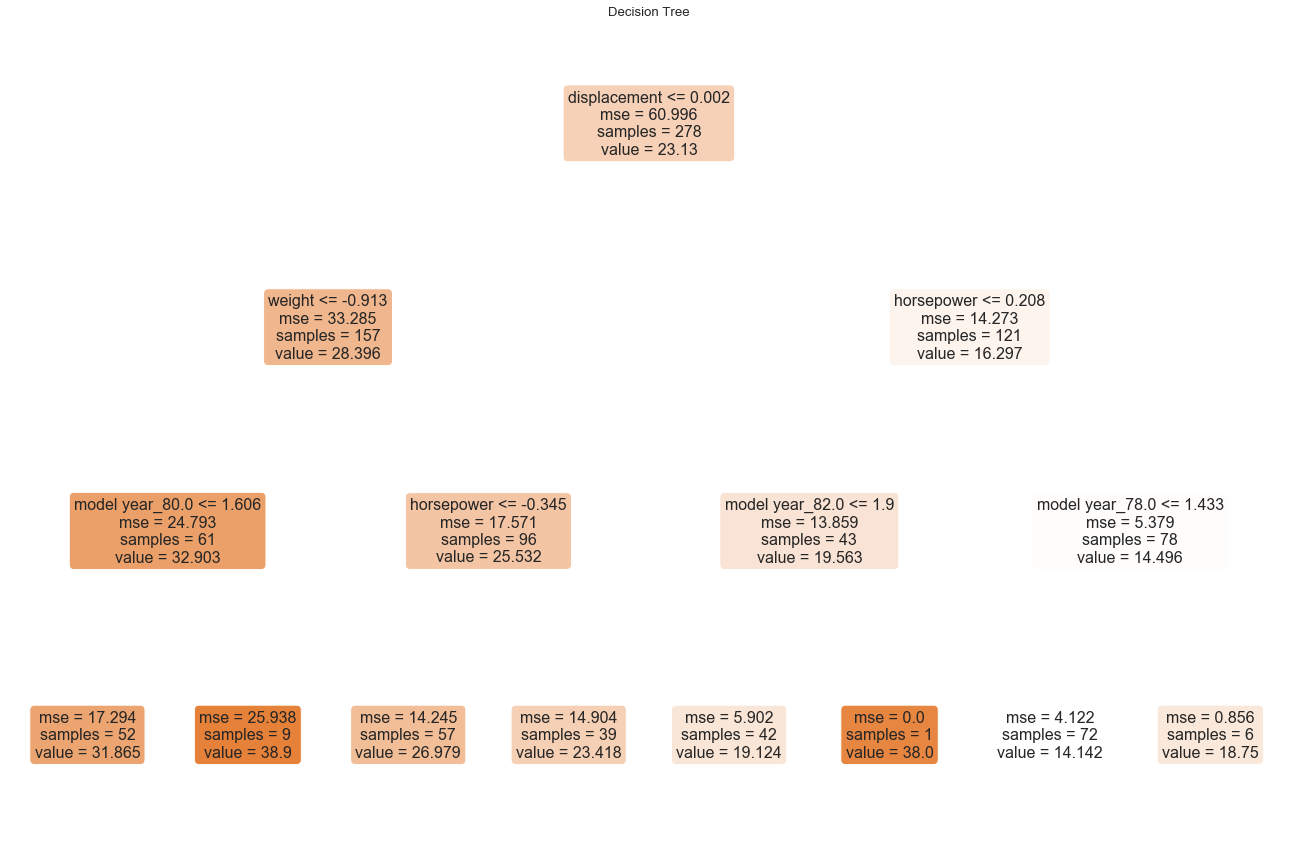

In [39]:
# Plot the tree.
fig=plt.figure(figsize=(23,15))
tree.plot_tree(tr.fit(X_train, y_train),feature_names=X.columns,filled=True,rounded=True,fontsize=16);
plt.title('Decision Tree');

In [147]:
# Print the tree in a simplified version.
r = export_text(tr, feature_names=X.columns.tolist())
print(r)

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [148]:
# Make predictions.
tr_pred=tr.predict(X_test)

# Calculate CV score.
cv_tr_reg=cross_val_score(tr, X_train, y_train, cv=10).mean()

## Decision tree Metrics

In [149]:
# Mean squared error (relative error).
print("Mean squared error (MSE): %.2f" % mean_squared_error(y_test, tr_pred))

# Mean absolute error (average error).
print("Mean absolute error (MAE): %.2f" % mean_absolute_error(y_test, tr_pred))

# Cross-Validation accuracy.
print('Cross-validation accuracy: %0.1f' % (cv_tr_reg*100),'%')

# Accuracy score: 1 is perfect prediction.
print('Accuracy: %.1f' % (tr.score(X_test, y_test)*100),'%')

Mean squared error (MSE): 12.16
Mean absolute error (MAE): 2.58
Cross-validation accuracy: 77.2 %
Accuracy: 79.6 %


## Grid search for Decision tree

In [46]:
# Hyperparameters to be checked.
parameters = {'criterion':['mse','friedman_mse','mae'],
              'splitter':['best','random'],
              'max_depth':[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],
              'min_samples_leaf':[2,3,5,10,20]
             }

# MLP estimator.
default_tr = tree.DecisionTreeRegressor(random_state=25)

# GridSearchCV estimator.
gs_tree = GridSearchCV(default_tr, parameters, cv=10, n_jobs=-1,verbose=1)

# Train the GridSearchCV estimator and search for the best parameters.
gs_tree.fit(X_train,y_train)

Fitting 10 folds for each of 600 candidates, totalling 6000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 620 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 3320 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed:   21.5s finished
C:\Users\DeusExMachina\.conda\envs\ml\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.



GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=DecisionTreeRegressor(criterion='mse', max_depth=None,
                                             max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort=False, random_state=25,
                                             splitter='best'),
             iid='warn', n_jobs=-1,
             param_grid={'criterion': ['mse', 'friedman_mse', 'mae'],
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15, 16, 17, 18, 19, 

In [47]:
# Make predictions with the best parameters.
gs_tree_pred=gs_tree.predict(X_test)

## Grid search Metrics for Decision tree

In [48]:
# Best parameters.
print("Best Decision tree Parameters: {}".format(gs_tree.best_params_))

# Mean squared error (relative error).
print("Mean squared error (MSE): %.2f" % mean_squared_error(y_test, gs_tree_pred))

# Mean absolute error (average error).
print("Mean absolute error (MAE): %.2f" % mean_absolute_error(y_test, gs_tree_pred))

# Cross validation accuracy for the best parameters.
print('Cross-validation accuracy: %0.1f' % (gs_tree.best_score_*100),'%')

# Accuracy score: 1 is perfect prediction.
print('Accuracy: %.1f' % (gs_tree.score(X_test, y_test)*100),'%')

Best Decision tree Parameters: {'criterion': 'mse', 'max_depth': 8, 'min_samples_leaf': 3, 'splitter': 'random'}
Mean squared error (MSE): 18.53
Mean absolute error (MAE): 3.22
Cross-validation accuracy: 74.1 %
Accuracy: 68.9 %


## Neural network (MLP)

In [150]:
# Initialize a Multi-layer Perceptron classifier.
mlp = MLPRegressor(max_iter=1000, random_state=25,shuffle=True, verbose=False)

# Train the classifier.
mlp.fit(X_train, y_train)

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(100,), learning_rate='constant',
             learning_rate_init=0.001, max_iter=1000, momentum=0.9,
             n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
             random_state=25, shuffle=True, solver='adam', tol=0.0001,
             validation_fraction=0.1, verbose=False, warm_start=False)

In [151]:
# Make predictions.
mlp_pred = mlp.predict(X_test)

# Calculate CV score.
cv_mlp_reg=cross_val_score(mlp, X_train, y_train, cv=10).mean()

## Neural network (MLP) metrics

In [152]:
# Mean squared error (relative error).
print("Mean squared error (MSE): %.2f" % mean_squared_error(y_test, mlp_pred))

# Mean absolute error (average error).
print("Mean absolute error (MAE): %.2f" % mean_absolute_error(y_test, mlp_pred))

# Cross-Validation accuracy
print('Cross-validation accuracy: %0.1f' % (cv_mlp_reg*100),'%')

# Accuracy score: 1 is perfect prediction.
print('Accuracy: %.1f' % (mlp.score(X_test, y_test)*100),'%')

Mean squared error (MSE): 7.67
Mean absolute error (MAE): 2.00
Cross-validation accuracy: 84.7 %
Accuracy: 87.1 %


## Grid search for Neural network (MLP)

In [52]:
# Hyperparameters to be checked.
parameters = {'activation':['logistic','tanh','relu'],
              'solver': ['lbfgs','adam','sgd'],
              'alpha': 10.0 ** -np.arange(1,3),
              'learning_rate': ['constant', 'invscaling', 'adaptive'],
              'hidden_layer_sizes':[(7),(6),(14),(3),(7,3),(6,3),(14,7),(3,1)]}

# Decision tree estimator.
default_mlp = MLPRegressor(max_iter=1000, random_state=25,shuffle=True, verbose=False)

# GridSearchCV estimator.
gs_mlp = GridSearchCV(default_mlp, parameters, cv=10, n_jobs=-1,verbose=1)

# Train the GridSearchCV estimator and search for the best parameters.
gs_mlp.fit(X_train,y_train)

Fitting 10 folds for each of 432 candidates, totalling 4320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 10.2min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 14.7min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed: 20.3min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed: 26.0min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 31.9min
[Parallel(n_jobs=-1)]: Done 4320 out of 4320 | elapsed: 34.0min finished
C:\Users\DeusExMachina\.conda\envs\ml\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are une

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=MLPRegressor(activation='relu', alpha=0.0001,
                                    batch_size='auto', beta_1=0.9, beta_2=0.999,
                                    early_stopping=False, epsilon=1e-08,
                                    hidden_layer_sizes=(100,),
                                    learning_rate='constant',
                                    learning_rate_init=0.001, max_iter=1000,
                                    momentum=0.9, n_iter_no_change=10,
                                    nesterovs_momentum=True, power_t=0.5,
                                    random_st...
                                    validation_fraction=0.1, verbose=False,
                                    warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'activation': ['logistic', 'tanh', 'relu'],
                         'alpha': array([0.1 , 0.01]),
                         'hidden_laye

In [53]:
# Make predictions with the best parameters.
gs_mlp_pred=gs_mlp.predict(X_test)

## Grid search MLP metrics

In [54]:
# Best parameters.
print("Best MLP Regression Parameters: {}".format(gs_mlp.best_params_))

# Mean squared error (relative error).
print("Mean squared error (MSE): %.2f" % mean_squared_error(y_test, gs_mlp_pred))

# Mean absolute error (average error).
print("Mean absolute error (MAE): %.2f" % mean_absolute_error(y_test, gs_mlp_pred))

# Cross validation accuracy for the best parameters.
print('Cross-validation accuracy: %0.1f' % (gs_mlp.best_score_*100),'%')

# Accuracy score: 1 is perfect prediction.
print('Accuracy: %.1f' % (gs_mlp.score(X_test, y_test)*100),'%')

Best MLP Regression Parameters: {'activation': 'logistic', 'alpha': 0.1, 'hidden_layer_sizes': (14, 7), 'learning_rate': 'constant', 'solver': 'sgd'}
Mean squared error (MSE): 7.05
Mean absolute error (MAE): 1.89
Cross-validation accuracy: 85.0 %
Accuracy: 88.2 %


## Results

In [59]:
metrics=['MSE','MAE','CV accuracy','Accuracy']

# Plot metrics.
fig = go.Figure(data=[
    go.Bar(name='Linear Regression', x=metrics, y=[mean_squared_error(y_test, lin_pred),mean_absolute_error(y_test, lin_pred),cv_lin_reg,linreg.score(X_test, y_test)]),
    go.Bar(name='Decision tree', x=metrics, y=[mean_squared_error(y_test, tr_pred),mean_absolute_error(y_test, tr_pred),cv_tr_reg,tr.score(X_test, y_test)]),
    go.Bar(name='Neural Network', x=metrics, y=[mean_squared_error(y_test, mlp_pred),mean_absolute_error(y_test, mlp_pred),cv_mlp_reg,mlp.score(X_test, y_test)]),
    go.Bar(name='GridSearch+Linear Regression', x=metrics, y=[mean_squared_error(y_test, gs_linreg_pred),mean_absolute_error(y_test, gs_linreg_pred),gs_linreg.best_score_,gs_linreg.score(X_test, y_test)]),
    go.Bar(name='GridSearch+Decision tree', x=metrics, y=[mean_squared_error(y_test, gs_tree_pred),mean_absolute_error(y_test, gs_tree_pred),gs_tree.best_score_,gs_tree.score(X_test, y_test)]),
    go.Bar(name='GridSearch+Neural Network', x=metrics, y=[mean_squared_error(y_test, gs_mlp_pred),mean_absolute_error(y_test, gs_mlp_pred),gs_mlp.best_score_,gs_mlp.score(X_test, y_test)])
])

fig.update_layout(title_text='Results',
                  barmode='group',xaxis_tickangle=-45,bargroupgap=0.05)
fig.show()

In [60]:
d={
'': ['Linear Regression','GridSearchCV + Linear Regression','Decision Tree','GridSearchCV + Decision Tree','Neural Network (MLP)','GridSearchCV + Neural Network (MLP)'],
    'MSE': [mean_squared_error(y_test, lin_pred), mean_squared_error(y_test, gs_linreg_pred),mean_squared_error(y_test, tr_pred),mean_squared_error(y_test, gs_tree_pred),mean_squared_error(y_test, mlp_pred),mean_squared_error(y_test, gs_mlp_pred)],
    'MAE': [mean_absolute_error(y_test, lin_pred), mean_absolute_error(y_test, gs_linreg_pred),mean_absolute_error(y_test, tr_pred),mean_absolute_error(y_test, gs_tree_pred),mean_absolute_error(y_test, mlp_pred),mean_absolute_error(y_test, gs_mlp_pred)],
    'CV Accuracy': [cv_lin_reg, gs_linreg.best_score_, cv_tr_reg,gs_tree.best_score_,cv_mlp_reg,gs_mlp.best_score_],
    'Accuracy': [linreg.score(X_test, y_test), gs_linreg.score(X_test,y_test),tr.score(X_test, y_test),gs_tree.score(X_test,y_test),mlp.score(X_test, y_test),gs_mlp.score(X_test, y_test)]
}

results=pd.DataFrame(data=d).round(3).set_index('')
results

,MSE,MAE,CV Accuracy,Accuracy
,,,,
Linear Regression,8.385,2.103,0.834,0.859
GridSearchCV + Linear Regression,8.385,2.103,0.835,0.859
Decision Tree,21.924,3.472,0.740,0.633
GridSearchCV + Decision Tree,18.529,3.223,0.741,0.689
Neural Network (MLP),6.585,1.865,0.819,0.890
GridSearchCV + Neural Network (MLP),7.053,1.893,0.850,0.882


## Quinlan's results

|                   | Mean squared error (MSE) | Mean absolute error (MAE) |
|-------------------|:------------------------:|:-------------------------:|
| Linear Regression |           19.4           |            2.61           |
| Decision tree     |           14.7           |            2.11           |
| Neural Network    |           12.5           |            2.02           |